#### Why Segmentation

If you want to increase retention rate, you can do a segmentation based on churn probability and take actions. But there are very common and useful segmentation methods as well. Now we are going to implement one of them to our business: RFM.

#### RFM stands for Recency - Frequency - Monetary Value. Theoretically we will have segments like below:

- **Low Value:** Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.

- **Mid Value:** In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.

- **High Value:** The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

In [1]:
# ∗∗∗∗∗∗∗∗∗∗ Important – Do not use in production, for demonstration purposes only – please review the legal notices before continuing ∗∗∗∗∗

# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division


StatementMeta(RetailSparkPool, 27, 1, Finished, Available)

ImportError: this version of pandas is incompatible with numpy < 1.13.3
your numpy version is 1.13.1.
Please upgrade numpy to >= 1.13.3 to use this pandas version

In [ ]:
#!conda install -c conda-forge cufflinks-py
#!conda install -c plotly chart-studio

import chart_studio
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.offline as pyoff


StatementMeta(, , , Cancelled, )

In [ ]:
#inititate Plotly
pyoff.init_notebook_mode()

StatementMeta(, , , Cancelled, )

###### As the methodology, we need to calculate Recency, Frequency and Monetary Value (we will call it Revenue from now on) and apply unsupervised machine learning to identify different groups (clusters) for each. Let’s jump into coding and see how to do RFM Clustering.

In [ ]:
#load dataset
#data source: https://www.kaggle.com/vijayuv/onlineretail
import pip
pip.main(["install", "xlrd"])
tx_data = pd.read_excel('abfss://customer-churn-data@#STORAGE_ACCOUNT_NAME#.dfs.core.windows.net/online_retail_II.xlsx')

StatementMeta(, , , Cancelled, )

In [5]:
#lets see the dataset
tx_data

StatementMeta(RetailPool, 35, 5, Finished, Available)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [6]:
tx_data.dropna(inplace=True)

StatementMeta(RetailPool, 35, 6, Finished, Available)

In [7]:
df_cancel = tx_data[tx_data["Invoice"].str.contains("C",na = False)]
tx_data = tx_data[~tx_data.Invoice.isin(df_cancel.Invoice)]

StatementMeta(RetailPool, 35, 7, Finished, Available)

In [8]:
#convert the string date field to datetime
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

StatementMeta(RetailPool, 35, 8, Finished, Available)

In [9]:
tx_data['InvoiceDate'].describe()

StatementMeta(RetailPool, 35, 9, Finished, Available)

count                  407695
unique                  18010
top       2010-03-07 15:34:00
freq                      270
first     2009-12-01 07:45:00
last      2010-12-09 20:01:00
Name: InvoiceDate, dtype: object

<stdin>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

In [10]:
#we will be using only UK data (we can filter data for others countries also)
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

StatementMeta(RetailPool, 35, 10, Finished, Available)

In [11]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
tx_user = pd.DataFrame(tx_data['Customer ID'].unique())
tx_user.columns = ['Customer ID']

StatementMeta(RetailPool, 35, 11, Finished, Available)

# Recency

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [12]:
tx_user

StatementMeta(RetailPool, 35, 12, Finished, Available)

,Customer ID
0,13085.0
1,13078.0
2,15362.0
3,18102.0
4,12682.0
...,...
4309,18269.0
4310,13270.0
4311,12942.0
4312,13369.0


In [13]:
#get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = tx_uk.groupby('Customer ID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['Customer ID','MaxPurchaseDate']
tx_max_purchase

StatementMeta(RetailPool, 35, 13, Finished, Available)

,Customer ID,MaxPurchaseDate
0,12346.0,2010-06-28 13:53:00
1,12608.0,2010-10-31 10:49:00
2,12745.0,2010-08-10 10:14:00
3,12746.0,2010-06-17 10:41:00
4,12747.0,2010-12-05 15:38:00
...,...,...
3966,18283.0,2010-11-22 15:30:00
3967,18284.0,2010-10-04 11:33:00
3968,18285.0,2010-02-17 10:24:00
3969,18286.0,2010-08-20 11:57:00


In [14]:
#we take our observation point as the max invoice date in our dataset
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

StatementMeta(RetailPool, 35, 14, Finished, Available)

In [15]:
tx_max_purchase.head()

StatementMeta(RetailPool, 35, 15, Finished, Available)

,Customer ID,MaxPurchaseDate,Recency
0,12346.0,2010-06-28 13:53:00,164
1,12608.0,2010-10-31 10:49:00,39
2,12745.0,2010-08-10 10:14:00,121
3,12746.0,2010-06-17 10:41:00,175
4,12747.0,2010-12-05 15:38:00,4


In [16]:
#merge this dataframe to our new user dataframe
#Our new dataframe tx_user contains recency data now:

tx_user = pd.merge(tx_user, tx_max_purchase[['Customer ID','Recency']], on='Customer ID')
tx_user.head()

StatementMeta(RetailPool, 35, 16, Finished, Available)

,Customer ID,Recency
0,13085.0,314
1,13078.0,1
2,15362.0,83
3,18102.0,0
4,18087.0,14


In [17]:
#To get a snapshot about how recency looks like, we can use pandas’ .describe() method. 
#It shows mean, min, max, count and percentiles of our data.
tx_user.Recency.describe()

StatementMeta(RetailPool, 35, 17, Finished, Available)

count    3971.000000
mean       90.200705
std        97.161543
min         0.000000
25%        17.000000
50%        52.000000
75%       135.000000
max       373.000000
Name: Recency, dtype: float64

We see that even though the average is 90 day recency, median is 49.

#### to show us how is the distribution of recency across our customers.

In [18]:
#plot a recency histogram
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

StatementMeta(RetailPool, 35, 18, Finished, Available)

- Now it is the fun part. We are going to apply K-means clustering to assign a recency score. But we should tell how many clusters we need to K-means algorithm. 

- To find it out, we will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia. Code snippet and Inertia graph are as follows:

StatementMeta(RetailPool, 35, 19, Finished, Available)

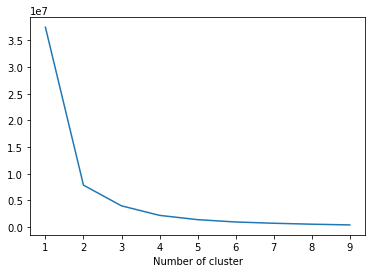

In [19]:
from sklearn.cluster import KMeans

sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Here it looks like 3 is the optimal one. we can go ahead with less or more clusters. We will be selecting 4 for this example:

In [20]:
#build 4 clusters for recency and add it to dataframe

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

StatementMeta(RetailPool, 35, 20, Finished, Available)

We have calculated clusters and assigned them to each Customer in our dataframe tx_user.

In [21]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

StatementMeta(RetailPool, 35, 21, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1966.0,19.793998,14.239993,0.0,8.0,17.0,30.0,50.0
1,555.0,192.715315,30.779143,139.0,166.5,191.0,218.0,247.0
2,418.0,306.868421,40.072768,252.0,272.0,301.0,356.0,373.0
3,1032.0,81.437984,24.220536,51.0,62.0,73.0,98.0,137.0


In [22]:
#function for ordering cluster numbers

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


StatementMeta(RetailPool, 35, 22, Finished, Available)

We have added one function to our code which is order_cluster(). K-means assigns clusters as numbers but not in an ordered way. We can’t say cluster 0 is the worst and cluster 4 is the best. order_cluster() method does this for us and our new dataframe looks much neater:

In [23]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)
tx_user.groupby('RecencyCluster')['Recency'].describe()

StatementMeta(RetailPool, 35, 23, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,418.0,306.868421,40.072768,252.0,272.0,301.0,356.0,373.0
1,555.0,192.715315,30.779143,139.0,166.5,191.0,218.0,247.0
2,1032.0,81.437984,24.220536,51.0,62.0,73.0,98.0,137.0
3,1966.0,19.793998,14.239993,0.0,8.0,17.0,30.0,50.0


### Great! 3 covers most recent customers whereas 0 has the most inactive ones.
#### Let’s apply same for Frequency and Revenue.

# Frequency

To create frequency clusters, we need to find total number orders for each customer. First calculate this and see how frequency look like in our customer database:

In [24]:
#get order counts for each user and create a dataframe with it
tx_frequency = tx_uk.groupby('Customer ID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['Customer ID','Frequency']
tx_frequency.head()

StatementMeta(RetailPool, 35, 24, Finished, Available)

,Customer ID,Frequency
0,12346.0,33
1,12608.0,16
2,12745.0,22
3,12746.0,17
4,12747.0,154


In [25]:
#add this data to our main dataframe

tx_user = pd.merge(tx_user, tx_frequency, on='Customer ID')
tx_user.head()

StatementMeta(RetailPool, 35, 25, Finished, Available)

,Customer ID,Recency,RecencyCluster,Frequency
0,13085.0,314,0,62
1,15413.0,326,0,25
2,17592.0,373,0,13
3,17056.0,373,0,8
4,13526.0,373,0,44


In [26]:
tx_user.Frequency.describe()

StatementMeta(RetailPool, 35, 26, Finished, Available)

count    3971.000000
mean       93.415009
std       183.278691
min         1.000000
25%        18.000000
50%        43.000000
75%       102.000000
max      5043.000000
Name: Frequency, dtype: float64

In [27]:
#plot the histogram

plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

StatementMeta(RetailPool, 35, 27, Finished, Available)

StatementMeta(RetailPool, 35, 28, Finished, Available)

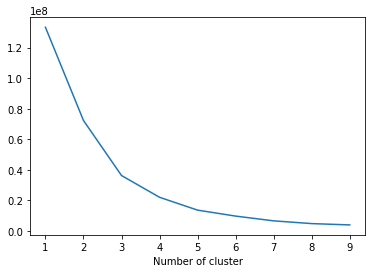

<stdin>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<stdin>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<stdin>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<stdin>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a Data

In [28]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Apply the same logic for having frequency clusters and assign this to each customer:

In [29]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

StatementMeta(RetailPool, 35, 29, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,594.0,246.447811,86.697891,146.0,177.00,224.0,292.75,500.0
1,3289.0,43.716023,36.070325,1.0,15.00,33.0,65.00,145.0
2,6.0,3061.000000,1158.777114,2055.0,2326.50,2566.5,3558.00,5043.0
3,82.0,761.134146,282.709019,509.0,578.25,653.0,813.00,1729.0


Characteristics of our frequency clusters look like below:


In [30]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)
tx_user

StatementMeta(RetailPool, 35, 30, Finished, Available)

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,13085.0,314,0,62,0
1,15413.0,326,0,25,0
2,17592.0,373,0,13,0
3,17056.0,373,0,8,0
4,13526.0,373,0,44,0
...,...,...,...,...,...
3966,17841.0,0,3,5043,3
3967,14606.0,1,3,3866,3
3968,12748.0,0,3,2634,3
3969,17850.0,7,3,2499,3


###### As the same notation as recency clusters, high frequency number indicates better customers.

# Revenue

Let’s see how our customer database looks like when we cluster them based on revenue. We will calculate revenue for each customer, plot a histogram and apply the same clustering method.

In [31]:
#calculate revenue for each customer
tx_uk['Revenue'] = tx_uk['Price'] * tx_uk['Quantity']
tx_revenue = tx_uk.groupby('Customer ID').Revenue.sum().reset_index()
tx_revenue.head()

StatementMeta(RetailPool, 35, 31, Finished, Available)

,Customer ID,Revenue
0,12346.0,372.86
1,12608.0,415.79
2,12745.0,723.85
3,12746.0,254.55
4,12747.0,5080.53


In [32]:
#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, on='Customer ID')

StatementMeta(RetailPool, 35, 32, Finished, Available)

In [33]:
tx_user.Revenue.describe()

StatementMeta(RetailPool, 35, 33, Finished, Available)

count      3971.000000
mean       1867.226382
std        7379.089721
min           0.000000
25%         304.110000
50%         669.850000
75%        1655.135000
max      349164.350000
Name: Revenue, dtype: float64

In [34]:
#plot the histogram

plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

StatementMeta(RetailPool, 35, 34, Finished, Available)

We have some customers with negative revenue as well. Let’s continue and apply k-means clustering:

In [35]:
import warnings
warnings.filterwarnings("ignore")

StatementMeta(RetailPool, 35, 35, Finished, Available)

StatementMeta(RetailPool, 35, 36, Finished, Available)

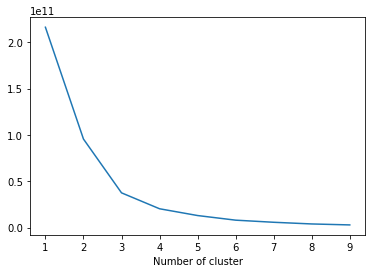

In [36]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [37]:
#apply clustering

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

StatementMeta(RetailPool, 35, 37, Finished, Available)

In [38]:
#order the cluster numbers

tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

StatementMeta(RetailPool, 35, 38, Finished, Available)

In [39]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

StatementMeta(RetailPool, 35, 39, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3819.0,1133.525221,1272.325485,0.00,293.895,633.99,1492.260,7021.66
1,135.0,13009.479430,6349.798143,7111.18,8270.545,10533.87,15674.300,32451.60
2,16.0,61273.691875,24068.562294,38683.02,45629.460,54212.78,69247.355,131443.19
3,1.0,349164.350000,NaN,349164.35,349164.350,349164.35,349164.350,349164.35


# Overall Segmentation

Awesome! We have scores (cluster numbers) for recency, frequency & revenue. Let’s create an overall score out of them:

In [40]:
tx_user.head()

StatementMeta(RetailPool, 35, 40, Finished, Available)

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,13085.0,314,0,62,0,2017.20,0
1,15413.0,326,0,25,0,6798.72,0
2,17592.0,373,0,13,0,148.30,0
3,17056.0,373,0,8,0,128.60,0
4,13526.0,373,0,44,0,1182.00,0


In [41]:
#calculate overall score and use mean() to see details

tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user

StatementMeta(RetailPool, 35, 41, Finished, Available)

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,13085.0,314,0,62,0,2017.20,0,0
1,15413.0,326,0,25,0,6798.72,0,0
2,17592.0,373,0,13,0,148.30,0,0
3,17056.0,373,0,8,0,128.60,0,0
4,13526.0,373,0,44,0,1182.00,0,0
...,...,...,...,...,...,...,...,...
3966,13694.0,8,3,957,2,131443.19,2,7
3967,14298.0,10,3,1227,2,39667.19,2,7
3968,15311.0,0,3,2055,3,56003.26,2,8
3969,17850.0,7,3,2499,3,51208.87,2,8


In [42]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

StatementMeta(RetailPool, 35, 42, Finished, Available)

,Recency,Frequency,Revenue
OverallScore,,,
0,307.368039,22.230024,363.125092
1,193.693032,29.491525,572.147533
2,85.312762,47.219665,928.907228
3,25.355886,65.195535,1215.254434
4,17.059091,239.154545,3339.582257
5,14.074074,439.657407,11927.574935
6,8.093750,836.031250,16823.736563
7,6.600000,1996.400000,52446.326000
8,2.333333,1727.000000,152125.493333


#### The scoring above clearly shows us that customers with score 8 is our best customers whereas 0 is the worst.

In [43]:
tx_user.groupby('OverallScore')['Recency'].count()

StatementMeta(RetailPool, 35, 43, Finished, Available)

OverallScore
0     413
1     531
2     956
3    1478
4     440
5     108
6      32
7      10
8       3
Name: Recency, dtype: int64

To keep things simple, better we name these scores:
- 0 to 2: Low Value
- 3 to 4: Mid Value
- 5+: High Value

We can easily apply this naming on our dataframe:

In [44]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

tx_user

StatementMeta(RetailPool, 35, 44, Finished, Available)

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,13085.0,314,0,62,0,2017.20,0,0,Low-Value
1,15413.0,326,0,25,0,6798.72,0,0,Low-Value
2,17592.0,373,0,13,0,148.30,0,0,Low-Value
3,17056.0,373,0,8,0,128.60,0,0,Low-Value
4,13526.0,373,0,44,0,1182.00,0,0,Low-Value
...,...,...,...,...,...,...,...,...,...
3966,13694.0,8,3,957,2,131443.19,2,7,High-Value
3967,14298.0,10,3,1227,2,39667.19,2,7,High-Value
3968,15311.0,0,3,2055,3,56003.26,2,8,High-Value
3969,17850.0,7,3,2499,3,51208.87,2,8,High-Value


### Now, it is the best part. Let’s see how our segments distributed on a scatter plot:

In [45]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

StatementMeta(RetailPool, 35, 45, Finished, Available)

In [46]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

StatementMeta(RetailPool, 35, 46, Finished, Available)

In [47]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

StatementMeta(RetailPool, 35, 47, Finished, Available)

#### We can start taking actions with this segmentation. The main strategies are quite clear:
- High Value: Improve Retention
- Mid Value: Improve Retention + Increase Frequency
- Low Value: Increase Frequency*

#### Merge and save the data

In [48]:
merged_df = tx_user[['Customer ID','Segment']].merge(tx_data,on='Customer ID',how='left')
merged_df['Country'] = merged_df['Country'].astype('category')
merged_df['Segment'] = merged_df['Segment'].astype('category')

merged_df[['Country','Segment']] = merged_df[['Country','Segment']].apply(lambda x: x.cat.codes)

StatementMeta(RetailPool, 35, 48, Finished, Available)

In [49]:
merged_df.head()

StatementMeta(RetailPool, 35, 49, Finished, Available)

,Customer ID,Segment,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country
0,13085.0,1,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,1
1,13085.0,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,1
2,13085.0,1,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,1
3,13085.0,1,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,1
4,13085.0,1,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,1


In [50]:
merged_df.to_csv('abfss://customer-churn-data@#STORAGE_ACCOUNT_NAME#.dfs.core.windows.net/CustomerChurn.csv')

StatementMeta(RetailPool, 35, 50, Finished, Available)

--- Logging error ---
Traceback (most recent call last):
  File "/home/trusted-service-user/cluster-env/env/lib/python3.8/logging/__init__.py", line 1085, in emit
    msg = self.format(record)
  File "/home/trusted-service-user/cluster-env/env/lib/python3.8/site-packages/pip/_internal/utils/logging.py", line 211, in format
    if self.should_color():
  File "/home/trusted-service-user/cluster-env/env/lib/python3.8/site-packages/pip/_internal/utils/logging.py", line 197, in should_color
    if hasattr(real_stream, "isatty") and real_stream.isatty():
ValueError: I/O operation on closed file.
Call stack:
  File "/home/trusted-service-user/cluster-env/env/lib/python3.8/threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "/home/trusted-service-user/cluster-env/env/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/trusted-service-user/cluster-env/env/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self.